<a href="https://colab.research.google.com/github/nturley/blog/blob/main/Yowasp_sby.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Deps

In [ ]:
!pip install nmigen
!pip install nbmc
!npm i -g netlistsvg
!pip install parse

     |████████████████████████████████| 153kB 11.3MB/s 
  Created wheel for nmigen: filename=nmigen-0.2-cp36-none-any.whl size=169778 sha256=4e333dfce1316cf6e3809d96fae685e58cdff3025b199da513c155660ecb3d79
  Stored in directory: /root/.cache/pip/wheels/47/0f/c4/a5f4c9f18186d2b36cd98499488d0b68ac2cbf9a9db5c3bedf
Successfully built nmigen
     |████████████████████████████████| 6.5MB 8.0MB/s 
     |████████████████████████████████| 143kB 47.5MB/s 
     |████████████████████████████████| 30.5MB 152kB/s 
     |████████████████████████████████| 4.7MB 42.7MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
  Created wheel for nbmc: filename=nbmc-0.0.4-cp36-none-any.whl size=2704 sha256=d04de9cc97ee2fc8fbada8c4a6646aeca30a1c9817c0340ebe66bc0e6a029493
  Stored in directory: /root/.cache/pip/wheels/5a/dd/db/70f929de2ed4c65fbe98cae9a434b90d01f7f04fc218f89a3d
  Created wheel for wavedrom: filename=wavedrom-2.0.3.post2-py2.py3-none-any.whl size=32843 sha256=ba1b99a88aaffd23baad5a8e13b468f3

# Imports

In [ ]:
from nmigen import *
from nmigen.back import rtlil
from nmigen.asserts import Assert, Assume, Cover, Past
from nbmc import check, Result
from IPython.display import SVG, display
from parse import search, findall

# nMigen Design
This is a simple digital design with two optional sets of assertions, one that should pass and one that should succeed. We also display a schematic of the logic we are checking.

In [ ]:
%%savecodelines
class UpCounter(Elaboratable):
    def __init__(self, limit, formal=False, formal_fail=False):
        self.formal = formal
        self.formal_fail = formal_fail
        self.limit = limit

        # Ports
        self.en  = Signal()
        self.ovf = Signal()

        # State
        self.count = Signal(16)

    def elab_formal(self, m):
        m.d.sync += Assert(self.count <= self.limit)
        m.d.sync += Assume(ResetSignal() == False)
        with m.If(Past(self.en) == False):
            m.d.sync += Assert(self.count == Past(self.count))
        with m.If(Past(self.en)):
            with m.If(Past(self.count) < self.limit):
                m.d.sync += Assert(self.count == Past(self.count) + 1)
            with m.Else():
                m.d.sync += Assert(self.count == 0)

    def elab_formal_fail(self, m):
        m.d.sync += Assert(self.count <= self.limit)
        m.d.sync += Assume(ResetSignal() == False)
        with m.If(Past(self.en) == False):
            m.d.sync += Assert(self.count == Past(self.count))
        with m.If(Past(self.en)):
            with m.If(Past(self.count) < self.limit):
                m.d.sync += Assert(self.count == Past(self.count) + 2)
            with m.Else():
                m.d.sync += Assert(self.count == 0)

    def elaborate(self, platform):
        m = Module()

        m.d.comb += self.ovf.eq(self.count == self.limit)
        with m.If(self.en):
            with m.If(self.ovf):
                m.d.sync += self.count.eq(0)
            with m.Else():
                m.d.sync += self.count.eq(self.count + 1)

        if self.formal:
            self.elab_formal(m)
        if self.formal_fail:
            self.elab_formal_fail(m)

        return m


# Run Bounded Model Check Verification
Here we check the two sets of formal properties to see what results we get

In [ ]:
from IPython.core.magic import  (
    Magics, magics_class, cell_magic, line_magic
)

@magics_class
class SaveCodeLines(Magics):
    def __init__(self, shell=None,  **kwargs):
        super().__init__(shell=shell, **kwargs)
        self.code = None

    @cell_magic
    def savecodelines(self, line, cell):
        """store the cell in the store"""
        self.code = cell
        self.shell.run_cell(cell)

    @line_magic
    def showcodelines(self, line):
        """show all recorded statements"""
        return self.code

## use ipython load_ext mechanisme here if distributed
get_ipython().register_magics(SaveCodeLines)

In [ ]:
def bounded_model_check(design, ports):
    bmc_run = check(design, ports)
    if bmc_run.result == Result.PASS:
        print('Pass!')
    if bmc_run.result == Result.FAIL:
        search_format = 'Assert failed in top: {}:{linenumber:d}'
        line_num = search(search_format, str(bmc_run.stdout))['linenumber']
        step_format = 'Checking assertions in step {step_num:d}..'
        steps = findall(step_format, str(bmc_run.stdout))
        step_num = list(steps)[-1]['step_num']
        print(f'Fail! Assertion failed at step {step_num}')
        print(f'Failed assertion on line {line_num}')
        code = %showcodelines
        print('-------------------------------')
        print("\n".join(code.splitlines()[line_num-2:line_num+1]))
        print('-------------------------------')
        display(bmc_run.drawing)

Fail! Assertion failed at step 2
Failed assertion on line 32
-------------------------------
            with m.If(Past(self.count) < self.limit):
                m.d.sync += Assert(self.count == Past(self.count) + 2)
            with m.Else():
-------------------------------


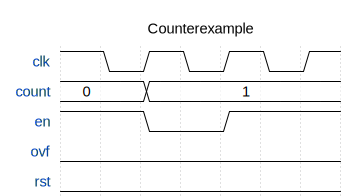

In [ ]:
design = UpCounter(5, formal_fail=True)
bounded_model_check(design, ports=[design.en, design.ovf])

In [ ]:
design = UpCounter(5, formal=True)
bounded_model_check(design, ports=[design.en, design.ovf])

Pass!
